**Домашнее задание 3 - 10 баллов**

В этом задании вам предстоит продолжить работу с зачадей машинного перевода из занятия 7.

Попробуйте улучшить качество модели, проверив следующие гипотезы:

- измените размер словаря / предобработку во время токенизации - **1 балл**
- продолжите эксперименты с различными RNN юнитами в encoder и decoder части: замена GRU/LSTM, изменение количества слоев, использование bidirectional RNN - **1 балл**
- улучшите процесс тренировки: добавьте lr sheduling, early stopping, поэкспериментируйте с оптимизатором - **2 балла**
- поэкспериментируйте с сэмплированием - замените greedy-инференс на альтернативные варианты - **2 балла**
- проведите ablation-study, сделайте выводы о влиянии ваших изменений на итоговую производительность модели - **2 балла**

**Общее**

- Принимаемые решения обоснованы (почему выбрана определенная архитектура/гиперпараметр/оптимизатор/преобразование и т.п.) - **1 балл**
- Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - **1 балл**

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import lightning as L
import wandb
import numpy as np
from torchtext.data.metrics import bleu_score
from nltk.tokenize import WordPunctTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tokenizers import Tokenizer, trainers, models, pre_tokenizers, decoders, processors
from torch.nn.utils.rnn import pad_sequence
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger

# Загрузка и предобработка данных

In [6]:
with open('data/data.txt', encoding='utf-8') as f:
    print(f.readlines()[0])

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



In [7]:
tokenizer = WordPunctTokenizer()


def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))


with open('data/train.en', 'w', encoding='utf-8') as f_src, open('data/train.ru', 'w', encoding='utf-8') as f_dst:
    for line in open('data/data.txt', encoding='utf-8'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# Обучение токенайзеров

In [ ]:
def train_bpe_tokenizer(dataset, vocab_size=10000):
    tokenizer = Tokenizer(models.BPE())

    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size, special_tokens=['[PAD]', '[SOS]', '[EOS]', '[UNK]'], end_of_word_suffix='##'
    )
    tokenizer.train_from_iterator(dataset, trainer)

    sos_token_id = tokenizer.token_to_id('[SOS]')
    eos_token_id = tokenizer.token_to_id('[EOS]')

    tokenizer.post_processor = processors.TemplateProcessing(
        single=f'[SOS] $A [EOS]',
        special_tokens=[('[SOS]', sos_token_id), ('[EOS]', eos_token_id)],
    )

    tokenizer.decoder = decoders.BPEDecoder(suffix='##')

    return tokenizer

In [196]:
src_texts = np.array(open('data/train.ru', encoding='utf-8').read().split('\n'))
tgt_texts = np.array(open('data/train.en', encoding='utf-8').read().split('\n'))

train_src, test_src, train_tgt, test_tgt = train_test_split(
    src_texts,
    tgt_texts,
    test_size=3000,
    random_state=42,
)

src_tokenizer = train_bpe_tokenizer(src_texts)
tgt_tokenizer = train_bpe_tokenizer(tgt_texts)

print(tgt_tokenizer.encode('example text in target language').tokens)
print(src_tokenizer.encode('пример текста на исходном языке').tokens)

['[SOS]', 'ex', 'ample##', 'tex', 't##', 'in##', 'tar', 'get##', 'langu', 'age##', '[EOS]']
['[SOS]', 'пример##', 'тек', 'ста##', 'на##', 'ис', 'ход', 'ном##', 'язы', 'ке##', '[EOS]']


In [197]:
print(tgt_tokenizer.encode('example text in target language').ids)
print(src_tokenizer.encode('пример текста на исходном языке').ids)

[1, 623, 2641, 4010, 190, 320, 2203, 2073, 7864, 645, 2]
[1, 4996, 2700, 2379, 338, 1313, 538, 395, 4333, 719, 2]


In [198]:
print(tgt_tokenizer.decode(tgt_tokenizer.encode('example text in target language').ids))

example text in target language


In [199]:
for vocab_size in [1000, 5000, 10000]:
    src_tokenizer = train_bpe_tokenizer(src_texts, vocab_size=vocab_size)
    tgt_tokenizer = train_bpe_tokenizer(tgt_texts, vocab_size=vocab_size)

    src_tokenizer.save(f'tokenizers/bpe_ru_{vocab_size}.json')
    tgt_tokenizer.save(f'tokenizers/bpe_en_{vocab_size}.json')

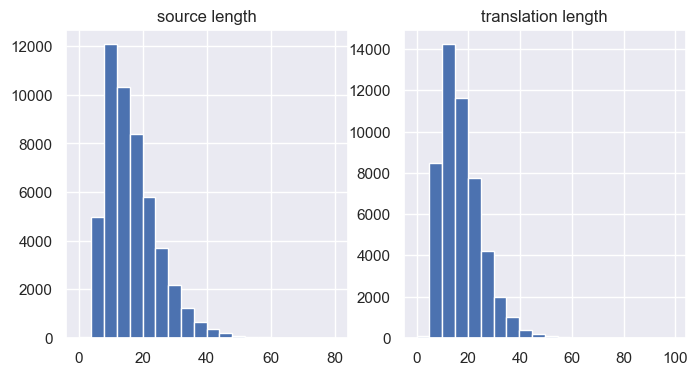

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title('source length')
plt.hist(list(map(len, map(str.split, src_texts))), bins=20)
plt.subplot(1, 2, 2)
plt.title('translation length')
plt.hist(list(map(len, map(str.split, tgt_texts))), bins=20);

In [201]:
src_tokenizer.get_vocab_size()

10000

# Датасет

In [202]:
class TranslationDataset(Dataset):
    def __init__(self, src_texts, tgt_texts, src_tokenizer, tgt_tokenizer):
        self.src_texts = src_texts
        self.tgt_texts = tgt_texts
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.PAD_TOKEN_ID = src_tokenizer.token_to_id('[PAD]')

    def __len__(self):
        return len(self.src_texts)

    def encode(self, text, tokenizer):
        tokens = tokenizer.encode(text).ids
        return tokens

    def __getitem__(self, idx):
        src = self.encode(self.src_texts[idx], self.src_tokenizer)
        tgt = self.encode(self.tgt_texts[idx], self.tgt_tokenizer)
        return torch.tensor(src), torch.tensor(tgt)


def collate_pad_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    PAD_TOKEN_ID = batch[0][0].new_tensor(src_tokenizer.token_to_id('[EOS]'))
    # на самом деле должен быть [PAD], но ориентируюсь на код с пары

    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=PAD_TOKEN_ID)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_TOKEN_ID)

    return src_batch, tgt_batch


train_dataset = TranslationDataset(train_src, train_tgt, src_tokenizer, tgt_tokenizer)
test_dataset = TranslationDataset(test_src, test_tgt, src_tokenizer, tgt_tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_pad_fn)
test_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=False, collate_fn=collate_pad_fn)

In [203]:
tgt_tokenizer.get_vocab_size()

10000

In [204]:
len(train_dataloader)

368

# Модель

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        super().__init__()
        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        batch_size, ninp, _ = enc.shape
        x = self.linear_dec(dec).unsqueeze(1) + self.linear_enc(enc)
        x = torch.tanh(x)
        x = self.linear_out(x).squeeze(-1)
        x = torch.where(inp_mask, x, torch.tensor(-1e9, device=x.device))
        probs = self.softmax(x)
        attn = torch.sum(probs.unsqueeze(-1) * enc, dim=1)
        return attn, probs


class AttentiveModel(L.LightningModule):
    def __init__(
        self,
        src_tokenizer,
        tgt_tokenizer,
        emb_size=64,
        hid_size=128,
        attn_size=128,
        src_vocab_size=10000,
        tgt_vocab_size=10000,
        eos_idx=2,
        sos_idx=1,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.src_tokenizer, self.tgt_tokenizer = src_tokenizer, tgt_tokenizer

        self.src_vocab_size = src_tokenizer.get_vocab_size()
        self.tgt_vocab_size = tgt_tokenizer.get_vocab_size()
        self.eos_idx = src_tokenizer.token_to_id('[EOS]')
        self.sos_idx = src_tokenizer.token_to_id('[EOS]')

        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(self.src_vocab_size, emb_size)
        self.emb_out = nn.Embedding(self.tgt_vocab_size, emb_size)
        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)
        self.logits = nn.Linear(hid_size, self.tgt_vocab_size)

    def encode(self, inp):
        inp_emb = self.emb_inp(inp)
        enc_seq, _ = self.enc0(inp_emb)
        lengths = (inp != self.eos_idx).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        inp_mask = inp != self.eos_idx
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)[1]
        return [dec_start, enc_seq, inp_mask, first_attn_probas]

    def decode_step(self, prev_state, prev_tokens):
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)
        x = torch.cat([attn, self.emb_out(prev_tokens)], dim=-1)
        x = self.dec0(x, prev_gru0_state)
        return [x, enc_seq, enc_mask, attn_probs], self.logits(x)

    def decode(self, initial_state, out_tokens):
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(
            torch.full([batch_size], self.sos_idx, dtype=torch.int64),
            num_classes=self.src_vocab_size,
        ).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]

        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def training_step(self, batch, batch_idx):
        inp, out = batch
        initial_state = self.encode(inp)
        logits = self.decode(initial_state, out)
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), out.view(-1), ignore_index=self.eos_idx)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inp, out = batch
        initial_state = self.encode(inp)
        logits = self.decode(initial_state, out)
        predictions = torch.argmax(logits, dim=-1)

        references = self.tgt_tokenizer.decode_batch(out.cpu().numpy())
        candidates = self.tgt_tokenizer.decode_batch(predictions.cpu().numpy())
        bleu = bleu_score(candidates, references)

        self.log('test_bleu', bleu, prog_bar=True)
        return {'bleu': bleu}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [210]:
def train():
    wandb_logger = WandbLogger(project='AttentionRNN')
    early_stop = EarlyStopping(monitor='train_loss', patience=3, mode='min')
    lr_monitor = LearningRateMonitor(logging_interval='step')
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = AttentiveModel(src_tokenizer, tgt_tokenizer)
    trainer = L.Trainer(max_epochs=50, callbacks=[early_stop, lr_monitor], logger=wandb_logger, accelerator=device)
    trainer.fit(model, train_dataloader, test_dataloader)

In [211]:
train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\ivawi\projects\aith_dl_nlp\.venv\Lib\site-packages\lightning\pytorch\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | emb_inp   | Embedding      | 640 K  | train
1 | emb_out   | Embedding      | 640 K  | train
2 | enc0      | LSTM           | 231 K  | train
3 | dec_start | Linear         | 16.5 K | train
4 | dec0      | GRUCell        | 123 K  | train
5 | attention | AttentionLayer | 33.2 K | train
6 | logits    | Linear         | 1.3 M  | train
-----------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ivawi\projects\aith_dl_nlp\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


AssertionError: The length of candidate and reference corpus should be the same

In [ ]:
wandb.finish()

In [54]:
# src_tokenizer = Tokenizer.from_file("tokenizers/bpe_ru_1000.json")